## Calculation of $B_{22}$, $p_B$ and $K_d$ from two-chain molecular simulations

Authors: Giulio Tesei and Thea Klarsø Schulze

Contact: giulio.tesei@bio.ku.dk

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')
from cycler import cycler
cm = ['#377eb8', '#ff7f00', '#4daf4a', '#999999', '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00','#000000']
plt.rc('axes', prop_cycle = cycler('color', cm))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

#### Helper Functions

In [2]:
def binding_dual_cutoff(input_array,lower,upper):
    binding_arr = np.zeros(len(input_array))
    frame_no = 0

    for ene in input_array:
        if ene <= lower:
            binding_arr[frame_no] = lower
        elif ene >= upper:
            binding_arr[frame_no] = upper
        elif lower < ene < upper:
            if binding_arr[frame_no-1] == lower:
                binding_arr[frame_no] = lower
            elif binding_arr[frame_no-1] == upper:
                binding_arr[frame_no] = upper
        else:
            print('error in {}'.format(frame_no))
        frame_no += 1

    # calculate number of frames in bound and unbound states

    # if limits are positive, bound and unbound states have the
    # same values as the upper and lower limit, respectively
    if lower > 0 and upper > 0:
        bound = np.count_nonzero(binding_arr == upper)
        unbound = np.count_nonzero(binding_arr == lower)

    # if limits are negative, bound and unbound states have the
    # same values as the lower and upper limit, respectively
    if lower < 0 and upper < 0:
        bound = np.count_nonzero(binding_arr == lower)
        unbound = np.count_nonzero(binding_arr == upper)

    return binding_arr, bound, unbound    
    
def kd_from_timeseries(p_bound,L):
    # Avogadro's number in units 1/mol
    N_A = 6.02214076*1e23
    # Volume of simulation box in L
    V = 1e3*(L*1e-09)**3
    # kd (in mol/L) determined from p_bound
    kd = ((1-p_bound)**2) / (N_A*V*p_bound)
    return kd

def kd_from_b22(b22,p_bound,L,MW):
    # Avogadro's number in units 1/mol
    N_A = 6.02214076*1e23
    # Volume of simulation box in L
    V = ((L*1e-09)**3)*1000
    # conversion factor for b22 (from µl mol / g2 to L) 
    convert_units = (MW**2)*1e-6/N_A
    return 1/(N_A*p_bound*(V-2*b22*convert_units))

def correctRDF(r,rdf,L):
    # Ganguly and van der Vegt, DOI: 10.1021/ct301017q
    dr = r[1]-r[0]
    V = L**3
    Nouter = 1 - 4/3*np.pi*r**3 / V
    DeltaN = 1/V*4*np.pi*dr*np.cumsum( (rdf - 1 ) * r**2)
    return rdf * Nouter / ( Nouter  - DeltaN)

def calcB22(r,rdf,MW):
    B22 = -2*np.pi*np.trapz((rdf-1)*r*r,r)
    return B22 * 6.022e23 / 1e21 / MW**2 * 1e3 # µl mol / g2

def calcB22blocks(df_rdf,L,MW):
    B22 = {}
    B22_E = {}
    B22_blocks = {}
    bootstrap = {}
    for m in ['M1','M2','M3']:
        B22_blocks[m] = []
        bootstrap[m] = []
        rdf = []
        for run in range(1,11):
            for k in range(4):
                y = df_rdf['{:s}_{:d}_{:d}'.format(m,run,k)]
                rdf.append(y)
                B22_blocks[m].append(calcB22(y.index,correctRDF(y.index,y.values,L),MW))
        for _ in range(1000):
            picked = random.choices(B22_blocks[m],k=len(B22_blocks[m]))
            bootstrap[m].append(np.mean(picked))
        mean = np.mean(rdf,axis=0)
        std = np.std(rdf,axis=0)
        rdf = df_rdf[m]
        crdf = correctRDF(df_rdf.index,rdf,L)
        B22[m] = calcB22(df_rdf.index,crdf,MW)
        B22_E[m] = np.std(B22_blocks[m])/np.sqrt(len(B22_blocks[m]))
    return B22, B22_E

def concatE(name,N_replicas):
    df_M1 = np.zeros(0)
    df_M2 = np.zeros(0)
    df_M3 = np.zeros(0)
    for i in range(1,N_replicas+1):
        df_M1 = np.append( df_M1, np.load('two-chain/data/maps/{:s}_M1_{:d}_energies.npy'.format(name,i)) )
        df_M2 = np.append( df_M2, np.load('two-chain/data/maps/{:s}_M2_{:d}_energies.npy'.format(name,i)) )
        df_M3 = np.append( df_M3, np.load('two-chain/data/maps/{:s}_M3_{:d}_energies.npy'.format(name,i)) )
    return {'M1':df_M1, 'M2':df_M2, 'M3':df_M3}

def calcPB(name,N_replicas,N,m):
    norm = N*np.log(N)
    energies = concatE(name,N_replicas)[m]/norm
    energies = energies[energies!=0]
    c1,c2 = -0.07,-0.05
    p_bound_list = []
    for i in range(1,N_replicas+1):
        energy = np.load('two-chain/data/maps/{:s}_{:s}_{:d}_energies.npy'.format(name,m,i))/norm
        binding_arr, bound, unbound = binding_dual_cutoff(energy, c1, c2)
        p_bound = bound / (bound + unbound)
        p_bound_list.append(p_bound)
    pB = np.mean(p_bound_list)
    pB_E = np.std(p_bound_list)
    return pB*1e2, pB_E*1e2

def scanCutoffs(name,N_replicas,box_size,m):
    proteins = pd.read_pickle('two-chain/proteins.pkl')
    residues = pd.read_csv('residues.csv').set_index('one')
    fasta = proteins.loc[name].fasta
    N = len(fasta)
    norm = N*np.log(N)
    MW = np.sum([residues.loc[r].MW for r in fasta])+18
    df_rdf = pd.read_pickle('two-chain/data/{:s}_rdfs.pkl'.format(name))
    b22 = calcB22blocks(df_rdf,box_size,MW)[0][m]
    emin = concatE(name,N_replicas)[m].min()/norm
    print(emin,10/norm)
    cutoffs = np.array([[i,j] for i in np.arange(-.15,0.01,.01) for j in np.arange(i+0.01,0,0.01)])    
    diff_list = [] 
    kd_ene_list = []
    kd_b22_list = [] 
    pB_list = [] 
    for k in cutoffs:
        # calculate p_bound for every cutoff combinations
        p_bound_list = []
        for i in range(1,N_replicas+1):
            energy = np.load('two-chain/data/maps/{:s}_{:s}_{:d}_energies.npy'.format(name,m,i))/norm
            binding_arr, bound, unbound = binding_dual_cutoff(energy,k[0],k[1])
            p_bound = bound / (bound + unbound)
            p_bound_list.append(p_bound)
        pB = np.average(p_bound_list)
        # calculate kd based on average p_bound
        kd_energies = kd_from_timeseries(pB,box_size)
        # calculate kd from b22, also using the average p_bound
        kd_b22 = kd_from_b22(b22,pB,box_size,MW)
        # calculate some kind of percentage difference between the two
        diff = abs(kd_energies-kd_b22) / (abs(kd_energies+kd_b22)/2) * 100
        # add results to dict
        diff_list.append(diff)
        kd_ene_list.append(kd_energies)
        kd_b22_list.append(kd_b22)
        pB_list.append(pB)
        df = pd.DataFrame(index=np.unique(cutoffs[:,0]),columns=np.unique(cutoffs[:,1]),dtype=float)
        for (i,j),e in zip(cutoffs,diff_list):
            df.loc[i,j] = e
    return df

def calcKd(name,N_replicas,box_size,m):
    proteins = pd.read_pickle('two-chain/proteins.pkl')
    residues = pd.read_csv('residues.csv').set_index('one')
    fasta = proteins.loc[name].fasta
    N = len(fasta)
    norm = N*np.log(N)
    MW = np.sum([residues.loc[r].MW for r in fasta])+18
    df_rdf = pd.read_pickle('two-chain/data/{:s}_rdfs.pkl'.format(name))
    b22, b22_E = calcB22blocks(df_rdf,box_size,MW)
    b22 = b22[m]
    b22_E = b22_E[m]
    c1,c2 = -0.07,-0.05
    p_bound_list = []
    for i in range(1,N_replicas+1):
        energy = np.load('two-chain/data/maps/{:s}_{:s}_{:d}_energies.npy'.format(name,m,i))/norm
        binding_arr, bound, unbound = binding_dual_cutoff(energy, c1, c2)
        p_bound = bound / (bound + unbound)
        p_bound_list.append(p_bound)
    pB = np.mean(p_bound_list)
    pB_E = np.std(p_bound_list)
    # calculate kd based on average p_bound
    kd_energies = kd_from_timeseries(pB,box_size)
    # calculate kd from b22, also using the average p_bound
    kd_b22 = kd_from_b22(b22,pB,box_size,MW)
    kd_err = np.std(kd_from_timeseries(np.array(p_bound_list),box_size))

    return (kd_energies+kd_b22)/2*1e3, kd_err*1e3, pB*1e2, pB_E*1e2, b22, b22_E

def calcKd_dual(name,N_replicas,box_size,m,
                cutoffs=[(-0.09,-0.03),(-0.08,-0.04),(-0.07,-0.04),(-0.07,-0.05),(-0.06,-0.05)]):
    proteins = pd.read_pickle('two-chain/proteins.pkl')
    residues = pd.read_csv('residues.csv').set_index('one')
    fasta = proteins.loc[name].fasta
    N = len(fasta)
    norm = N*np.log(N)
    MW = np.sum([residues.loc[r].MW for r in fasta])+18
    df_rdf = pd.read_pickle('two-chain/data/{:s}_rdfs.pkl'.format(name))
    b22, b22_E = calcB22blocks(df_rdf,box_size,MW)
    b22 = b22[m]
    b22_E = b22_E[m]
    pB_dual = []
    Kd_dual = []
    for c1,c2 in cutoffs:
        p_bound_list = []
        for i in range(1,N_replicas+1):
            energy = np.load('two-chain/data/maps/{:s}_{:s}_{:d}_energies.npy'.format(name,m,i))/norm
            binding_arr, bound, unbound = binding_dual_cutoff(energy, c1, c2)
            p_bound = bound / (bound + unbound)
            p_bound_list.append(p_bound)

        pB = np.mean(p_bound_list)
        kd_energies = kd_from_timeseries(pB,box_size)
        kd_b22 = kd_from_b22(b22,pB,box_size,MW)
        
        Kd_dual.append((kd_energies+kd_b22)/2*1e3)
        pB_dual.append(pB)

    return np.mean(Kd_dual),np.std(Kd_dual),np.mean(pB_dual)*1e2,np.std(pB_dual)*1e2,b22,b22_E

Calculate the second virial coefficient, $B_{22}$, from the RDF of the mass centers of the two chains.

In [3]:
# Load the RDFs calculated for the ten replicas divided into 4 blocks of 875 ns
FUS_rdfs = pd.read_pickle('two-chain/data/FUS_rdfs.pkl')
A2_rdfs = pd.read_pickle('two-chain/data/A2_rdfs.pkl')

# Calculate B22 estimating the error by boostrapping 1,000 times 40 B22 values calculated for the blocks 
B22_FUS, B22_FUS_E = calcB22blocks(FUS_rdfs,40.5,17168)
B22_A2, B22_A2_E = calcB22blocks(A2_rdfs,48,14690)

Plot the RDFs before and after correcting for the finite size of the simulation box according to [Ganguly and van der Vegt](https://doi.org/10.1021/ct301017q).

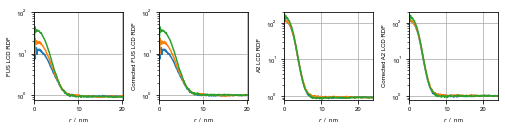

In [4]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(7,1.8))

for i,m in enumerate(['M1','M2','M3']):
    rdf = FUS_rdfs[m]
    crdf = correctRDF(rdf.index,rdf,40.5)
    ax1.plot(rdf.index,rdf.values,color=plt.cm.tab10(i),label=m)
    ax2.plot(rdf.index,crdf.values,color=plt.cm.tab10(i),label=m)
    rdf = A2_rdfs[m]
    crdf = correctRDF(rdf.index,rdf,48)
    ax3.plot(rdf.index,rdf.values,color=plt.cm.tab10(i),label=m)
    ax4.plot(rdf.index,crdf.values,color=plt.cm.tab10(i),label=m)
for ax in (ax1,ax2,ax3,ax4):
    ax.set_yscale('log')
    ax.set_xlabel('$r$  /  nm')
    ax.grid()
ax1.set_xlim(0,20.25)
ax2.set_xlim(0,20.25)
ax3.set_xlim(0,24)
ax4.set_xlim(0,24)
ax1.set_ylim(0.78,100)
ax2.set_ylim(0.78,100)
ax3.set_ylim(0.78,200)
ax4.set_ylim(0.78,200)
ax1.set_ylabel('FUS LCD RDF')
ax2.set_ylabel('Corrected FUS LCD RDF')
ax3.set_ylabel('A2 LCD RDF')
ax4.set_ylabel('Corrected A2 LCD RDF')
fig.tight_layout()    
plt.show()

We normalize the intermolecular non-electrostatic energy by $N\log{N}$, where $N$ is the sequence length, and scan the dual cutoffs, [$e_{l}$,$e_{u}$], within $-0.15<e_{l}<-0.02$ kJ mol$^{-1}$ and $e_{l}+0.01<e_{u}<-0.01$ kJ mol$^{-1}$.

In [5]:
df_a2_m1 = scanCutoffs('A2',10,48,'M1')

df_fus_m1 = scanCutoffs('FUS',10,40.5,'M1')

df_a2_m2 = scanCutoffs('A2',10,48,'M2')

df_fus_m2 = scanCutoffs('FUS',10,40.5,'M2')

df_a2_m3 = scanCutoffs('A2',10,48,'M3')

df_fus_m3 = scanCutoffs('FUS',10,40.5,'M3')

cutoffs = pd.DataFrame(columns=['FUS','A2'],index=['M1','M2','M3'])

all_x = np.empty(0)
all_y = np.empty(0)
for i,(a2,fus) in enumerate(zip([df_a2_m1,df_a2_m2,df_a2_m3],[df_fus_m1,df_fus_m2,df_fus_m3])):
    x1 = np.array(fus[fus < 5].stack().index.tolist())[:,0]
    y1 = np.array(fus[fus < 5].stack().index.tolist())[:,1]
    cutoffs.loc['M'+str(i+1),'FUS'] = [x1,y1]
    x2 = np.array(a2[a2 < 5].stack().index.tolist())[:,0]
    y2 = np.array(a2[a2 < 5].stack().index.tolist())[:,1]
    cutoffs.loc['M'+str(i+1),'A2'] = [x2,y2]
    all_x = np.append(all_x,np.concatenate([x1,x2]))
    all_y = np.append(all_y,np.concatenate([y1,y2]))
cutoffs.to_pickle('two-chain/data/cutoffs.pkl')

-0.20404194957946023 0.012792125893933654
-0.13435078488753208 0.012044111083778118
-0.20849619415690576 0.012792125893933654
-0.15464145756682274 0.012044111083778118
-0.2085484003411442 0.012792125893933654
-0.16191646817519467 0.012044111083778118


Load the intermolecular non-electrostatic energies for polyvaline chains of various length and calculate the absolute values of the minimum in the time series. 

In [6]:
polyV_length = [50,100,150,200,250,300,400]
frame_energies = {}
for N in polyV_length:
    ha = np.load('two-chain/data/polyV/{:s}_energies.npy'.format('V'+str(N)))
    frame_energies[N] = ha
frame_energies = pd.Series(frame_energies)
min_energy = frame_energies.apply(lambda x : abs(x.min()))

Calculate the fraction of frames where the proteins are in a dimeric bound state.

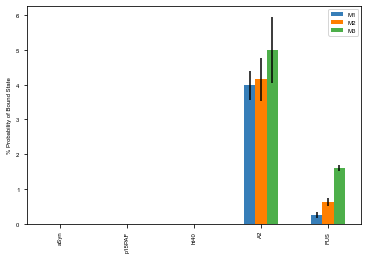

In [7]:
p = pd.read_pickle('two-chain/proteins.pkl')
dfpB = pd.DataFrame(index=['aSyn','p15PAF','ht40','A2','FUS'],columns=['M1','M2','M3'])
dfpB_E = dfpB.copy()
for name,N_replicas in zip(dfpB.index,[2,2,2,10,10]): 
    for m in ['M1','M2','M3']:
        a,b = calcPB(name,N_replicas,len(p.loc[name].fasta),m)
        dfpB.loc[name,m] = a
        dfpB_E.loc[name,m] = b
dfpB.plot.bar(yerr=dfpB_E)
plt.ylabel('% Probability of Bound State')
dfpB.to_pickle('two-chain/data/pB_values.pkl')
dfpB_E.to_pickle('two-chain/data/pB_errors.pkl')

Calculate the dissociation constant, $K_d$, estimating the error as the SD of the ten replicas

In [8]:
dfKd_A2 = pd.DataFrame(index=['M1','M2','M3'],columns=['Kd','Kd_E','pB','pB_E','B22','B22_E'])
dfKd_FUS = dfKd_A2.copy()
name = 'FUS'
for m in ['M1','M2','M3']:
    Kd, Kd_E, pB, pB_E, B22, B22_E = calcKd(name,N_replicas,p.loc[name].L,m)
    dfKd_FUS.loc[m,['Kd','Kd_E','pB','pB_E','B22','B22_E']] = Kd, Kd_E, pB, pB_E, B22, B22_E  
name = 'A2'
for m in ['M1','M2','M3']:
    Kd, Kd_E, pB, pB_E, B22, B22_E = calcKd(name,N_replicas,p.loc[name].L,m)
    dfKd_A2.loc[m,['Kd','Kd_E','pB','pB_E','B22','B22_E']] = Kd, Kd_E, pB, pB_E, B22, B22_E 
dfKd_A2.to_pickle('two-chain/data/dfB22KdpB_A2.pkl')
dfKd_FUS.to_pickle('two-chain/data/dfB22KdpB_FUS.pkl')

Calculate the dissociation constant, $K_d$, estimating the error as the SD of five dual cutoffs: (-0.09,-0.03), (-0.08,-0.04), (-0.07,-0.04), (-0.07,-0.05), (-0.06,-0.05)

In [9]:
dfKd_A2 = pd.DataFrame(index=['M1','M2','M3'],columns=['Kd','Kd_E','pB','pB_E','B22','B22_E'])
dfKd_FUS = dfKd_A2.copy()
name = 'FUS'
for m in ['M1','M2','M3']:
    Kd, Kd_E, pB, pB_E, B22, B22_E = calcKd_dual(name,N_replicas,p.loc[name].L,m)
    dfKd_FUS.loc[m,['Kd','Kd_E','pB','pB_E','B22','B22_E']] = Kd, Kd_E, pB, pB_E, B22, B22_E 
name = 'A2'
for m in ['M1','M2','M3']:
    Kd, Kd_E, pB, pB_E, B22, B22_E = calcKd_dual(name,N_replicas,p.loc[name].L,m)
    dfKd_A2.loc[m,['Kd','Kd_E','pB','pB_E','B22','B22_E']] = Kd, Kd_E, pB, pB_E, B22, B22_E 
dfKd_A2.to_pickle('two-chain/data/dfB22KdpB_dual_A2.pkl')
dfKd_FUS.to_pickle('two-chain/data/dfB22KdpB_dual_FUS.pkl')

Show the $N$-dependence of the intermolecular non-electrostatic energies for polyvaline chains. Find dual cutoffs that minimize the discrepancy between $K_d$ values calculated combining $p_B$ and $K_d$ or using only $p_B$. Show the difference in the SDs of the replicas and of the optimal dual cutoffs. 

In [10]:
B22KdpB_A2 = pd.read_pickle('two-chain/data/dfB22KdpB_A2.pkl')
B22KdpB_FUS = pd.read_pickle('two-chain/data/dfB22KdpB_FUS.pkl')
B22KdpB_dual_A2 = pd.read_pickle('two-chain/data/dfB22KdpB_dual_A2.pkl')
B22KdpB_dual_FUS = pd.read_pickle('two-chain/data/dfB22KdpB_dual_FUS.pkl')

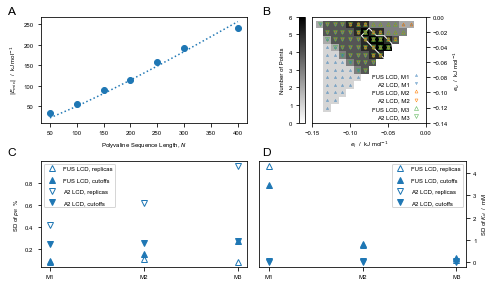

In [11]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(7,4))

cutoffs = pd.read_pickle('two-chain/data/cutoffs.pkl')
NlogN = lambda x,a: a*x*np.log(np.array(x))

all_x = np.empty(0)
all_y = np.empty(0)
for name in cutoffs.index:
    x1 = cutoffs.loc[name,'FUS'][0]
    y1 = cutoffs.loc[name,'FUS'][1]
    x2 = cutoffs.loc[name,'A2'][0]
    y2 = cutoffs.loc[name,'A2'][1]
    all_x = np.append(all_x,np.concatenate([x1,x2]))
    all_y = np.append(all_y,np.concatenate([y1,y2]))

min_energy.plot(ax=ax1,lw=0,color='tab:blue',marker='o')
ax1.set_xlabel('Polyvaline Sequence Length, $N$')
ax1.set_ylabel('$|E_{min}|$  /  kJ mol$^{-1}$')
NlogN_fit,_ = curve_fit(NlogN,min_energy.index,min_energy.values)
ax1.plot(min_energy.index,NlogN(min_energy.index,*NlogN_fit),color='tab:blue',linestyle='dotted')

for (model,data),c,ms in zip(cutoffs.iterrows(),cm[:3],[2,3,4]):
    ax2.plot(data.FUS[0],data.FUS[1],marker='^',color=c,mfc='None',lw=0,label='FUS LCD, '+model,
             ms=ms,markeredgewidth=.5)
    ax2.plot(data.A2[0],data.A2[1],marker='v',color=c,mfc='None',lw=0,label='A2 LCD, '+model,
             ms=ms,markeredgewidth=.5)
ax2.legend(frameon=False,markerfirst=False,handletextpad=.05,borderpad=.1)
ax2.set_ylabel('$e_u$  /  kJ mol$^{-1}$')
ax2.set_xlabel('$e_l$  /  kJ mol$^{-1}$')
bins = np.arange(-.15,0.01,0.01)
h, xbins, ybins = np.histogram2d(all_x,all_y,bins=bins,density=False)
im = ax2.imshow(h.T,extent=[xbins.min()-.005,xbins.max()-.005,ybins.min()+.005,ybins.max()+.005],origin='lower',
           cmap=plt.cm.binary)
ax2.contour(xbins[:-1]+.005,ybins[:-1]+.005,h.T,[5],origin='lower',colors=['w'],linewidths=[1])
ax2.set_xlim(-.15,0)
ax2.set_ylim(-.14,0)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("left", size='5%',pad=.1) 
fig.add_axes(cax2)
plt.colorbar(im, cax=cax2, orientation="vertical", label=r'Number of Points')
cax2.yaxis.set_ticks_position('left')
cax2.yaxis.set_label_position('left')

B22KdpB_FUS.pB_E.plot(ax=ax3,marker='^',lw=0,mfc='None',color='tab:blue',label='FUS LCD, replicas')
B22KdpB_dual_FUS.pB_E.plot(ax=ax3,marker='^',lw=0,color='tab:blue',label='FUS LCD, cutoffs')
B22KdpB_A2.pB_E.plot(ax=ax3,marker='v',lw=0,mfc='None',color='tab:blue',label='A2 LCD, replicas')
B22KdpB_dual_A2.pB_E.plot(ax=ax3,marker='v',lw=0,color='tab:blue',label='A2 LCD, cutoffs')

ax3.legend(frameon=True,markerfirst=True,labelspacing=1)
ax3.set_ylabel('SD of $p_B$  %')

B22KdpB_FUS.Kd_E.plot(ax=ax4,marker='^',lw=0,mfc='None',color='tab:blue',label='FUS LCD, replicas')
B22KdpB_dual_FUS.Kd_E.plot(ax=ax4,marker='^',lw=0,color='tab:blue',label='FUS LCD, cutoffs')
B22KdpB_A2.Kd_E.plot(ax=ax4,marker='v',lw=0,mfc='None',color='tab:blue',label='A2 LCD, replicas')
B22KdpB_dual_A2.Kd_E.plot(ax=ax4,marker='v',lw=0,color='tab:blue',label='A2 LCD, cutoffs')

ax2.set_xticks(np.arange(-.15,0.01,.05))
ax3.set_xticks(range(3))
ax4.set_xticks(range(3))

ax4.legend(frameon=True,markerfirst=True,labelspacing=1)
ax4.set_ylabel('SD of $K_d$  /  mM')

ax2.yaxis.set_ticks_position('right'); ax2.yaxis.set_label_position('right')
ax4.yaxis.set_ticks_position('right'); ax4.yaxis.set_label_position('right')

fig.text(0.02, .96, 'A', fontsize=12)
fig.text(0.525, .96, 'B', fontsize=12)
fig.text(0.02, .47, 'C', fontsize=12)
fig.text(0.525, .47, 'D', fontsize=12)

plt.tight_layout(pad=2)
plt.savefig('figures/Kd.pdf')